## Adversarial Attacks Evaluation

Evaluate robustness of baseline and lottery tickets under adversarial attacks (FGSM, PGD).

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import json
from pathlib import Path

from src.utils.config import load_config, get_device
from src.models.deep_hedging import create_model
from src.models.losses import create_loss_function
from src.data.heston import get_or_generate_dataset
from src.data.preprocessor import create_dataloaders, compute_features
from src.attacks.fgsm import create_fgsm_attack
from src.attacks.pgd import create_pgd_attack
from src.evaluation.metrics import compute_all_metrics, compute_robustness_metrics

### Setup

In [2]:
config = load_config('../configs/config.yaml')
device = get_device(config)
print(f"Using device: {device}")

# Extract key parameters
heston_config = config['data']['heston']
K = heston_config['K']
T = config['data']['T']
n_steps = config['data']['n_steps']
dt = T / n_steps

# Load test data
cache_dir = config.get('caching', {}).get('directory', 'cache')
S_test, v_test, Z_test = get_or_generate_dataset(config, 'test', cache_dir)

# Create test dataloader
batch_size = config.get('training', {}).get('batch_size', 256)
_, _, test_loader = create_dataloaders(
    S_test[:1000], v_test[:1000], Z_test[:1000],  # Dummy train/val
    S_test[:1000], v_test[:1000], Z_test[:1000],
    S_test, v_test, Z_test,
    batch_size=batch_size
)

print(f"Test set: {S_test.shape[0]} paths")
print(f"K={K}, T={T}, n_steps={n_steps}, dt={dt:.6f}")

[Config] Auto-detected device: cpu
Using device: cpu
[Heston] Loading cached test dataset from cache/test_c0f922ca.npz
Test set: 15000 paths
K=100.0, T=0.0833, n_steps=30, dt=0.002777


### Helper Functions

In [3]:
def evaluate_robustness(model, loss_fn, test_loader, config, device):
    """
    Evaluate model robustness against FGSM and PGD attacks.
    
    Returns:
        Dictionary with clean, FGSM, and PGD metrics
    """
    heston_config = config['data']['heston']
    K = heston_config['K']
    T = config['data']['T']
    n_steps = config['data']['n_steps']
    dt = T / n_steps
    
    model.eval()
    
    # Create attacks
    fgsm = create_fgsm_attack(model, loss_fn, config)
    pgd = create_pgd_attack(model, loss_fn, config)
    
    clean_pnls, fgsm_pnls, pgd_pnls = [], [], []
    
    for S, v, Z in test_loader:
        S, v, Z = S.to(device), v.to(device), Z.to(device)
        features = compute_features(S, v, K, T, dt)
        
        # Clean evaluation
        with torch.no_grad():
            deltas, y = model(features, S)
            pnl = loss_fn.compute_pnl(deltas, S, Z, dt)
            clean_pnls.append(pnl.cpu())
        
        # FGSM attack
        features_fgsm, _ = fgsm.attack(features, S, Z, dt)
        with torch.no_grad():
            deltas, y = model(features_fgsm, S)
            pnl = loss_fn.compute_pnl(deltas, S, Z, dt)
            fgsm_pnls.append(pnl.cpu())
        
        # PGD attack
        features_pgd, _ = pgd.attack(features, S, Z, dt)
        with torch.no_grad():
            deltas, y = model(features_pgd, S)
            pnl = loss_fn.compute_pnl(deltas, S, Z, dt)
            pgd_pnls.append(pnl.cpu())
    
    clean_pnls = torch.cat(clean_pnls).numpy()
    fgsm_pnls = torch.cat(fgsm_pnls).numpy()
    pgd_pnls = torch.cat(pgd_pnls).numpy()
    
    # Compute metrics
    clean_metrics = compute_all_metrics(clean_pnls)
    fgsm_metrics = compute_all_metrics(fgsm_pnls)
    pgd_metrics = compute_all_metrics(pgd_pnls)
    
    return {
        'clean': clean_metrics,
        'fgsm': fgsm_metrics,
        'pgd': pgd_metrics,
        'fgsm_gap': clean_metrics['pnl_mean'] - fgsm_metrics['pnl_mean'],
        'pgd_gap': clean_metrics['pnl_mean'] - pgd_metrics['pnl_mean'],
        'fgsm_cvar_gap': clean_metrics['cvar_05'] - fgsm_metrics['cvar_05'],
        'pgd_cvar_gap': clean_metrics['cvar_05'] - pgd_metrics['cvar_05']
    }

### Load Models

In [4]:
models_to_test = {}
loss_fn = create_loss_function(config)

# Baseline dense model
baseline_path = Path('../experiments/baseline/checkpoints/best.pt')
if baseline_path.exists():
    model_dense = create_model(config)
    checkpoint = torch.load(baseline_path, map_location=device)
    model_dense.load_state_dict(checkpoint['model_state_dict'])
    model_dense = model_dense.to(device)
    models_to_test['dense_baseline'] = model_dense
    print(f"Loaded dense baseline from {baseline_path}")
else:
    print(f"Dense baseline not found at {baseline_path}")

# Sparse tickets at different sparsity levels
for sparsity in [50, 60, 70, 80, 90, 95]:
    ticket_path = Path(f'../experiments/pruning/sparsity_{sparsity}/checkpoints/best.pt')
    if ticket_path.exists():
        model_sparse = create_model(config)
        checkpoint = torch.load(ticket_path, map_location=device)
        model_sparse.load_state_dict(checkpoint['model_state_dict'])
        model_sparse = model_sparse.to(device)
        models_to_test[f'ticket_{sparsity}%'] = model_sparse
        print(f"Loaded ticket {sparsity}% from {ticket_path}")
    else:
        print(f"Ticket {sparsity}% not found, skipping")

print(f"\nTotal models loaded: {len(models_to_test)}")

[Loss] Created OCELoss (CVaR α=0.05, TC=0.001)
[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
Loaded dense baseline from ../experiments/baseline/checkpoints/best.pt
[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
Loaded ticket 50% from ../experiments/pruning/sparsity_50/retrain_checkpoints/best.pt
[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
Loaded ticket 60% from ../experiments/pruning/sparsity_60/retrain_checkpoints/best.pt
[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
Loaded ticket 70% from ../experiments/pruning/sparsity_70/retrain_checkpoints/best.pt
[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
Loaded ticket 80% from ../experiments/pruning/sparsity

/var/folders/gy/pzm_9pc90xl1yp8rwj167s8w0000gn/T/ipykernel_76117/1439061811.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(baseline_path, map_lo

### Evaluate Robustness

In [5]:
results_attacks = {}

for model_name, model in models_to_test.items():
    print(f"\nEvaluating {model_name}...")
    
    results = evaluate_robustness(model, loss_fn, test_loader, config, device)
    results_attacks[model_name] = results
    
    print(f"  Clean CVaR:      {results['clean']['cvar_05']:.6f}")
    print(f"  FGSM CVaR:       {results['fgsm']['cvar_05']:.6f}")
    print(f"  PGD CVaR:        {results['pgd']['cvar_05']:.6f}")
    print(f"  PGD CVaR Gap:    {results['pgd_cvar_gap']:.6f}")

# Save results
output_dir = Path('../experiments/adversarial')
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'attack_results.json', 'w') as f:
    json.dump(results_attacks, f, indent=2, default=float)

print(f"\nResults saved to {output_dir / 'attack_results.json'}")


Evaluating dense_baseline...
[Attack] Created FGSM (ε=0.1)
[Attack] Created PGD (ε=0.1, α=0.01, steps=10, norm=linf)
  Clean CVaR:      -3.103180
  FGSM CVaR:       -4.791630
  PGD CVaR:        -11.225726
  PGD CVaR Gap:    8.122546

Evaluating ticket_50%...
[Attack] Created FGSM (ε=0.1)
[Attack] Created PGD (ε=0.1, α=0.01, steps=10, norm=linf)
  Clean CVaR:      -3.088542
  FGSM CVaR:       -5.299544
  PGD CVaR:        -11.122305
  PGD CVaR Gap:    8.033763

Evaluating ticket_60%...
[Attack] Created FGSM (ε=0.1)
[Attack] Created PGD (ε=0.1, α=0.01, steps=10, norm=linf)
  Clean CVaR:      -3.095154
  FGSM CVaR:       -6.448164
  PGD CVaR:        -11.308944
  PGD CVaR Gap:    8.213789

Evaluating ticket_70%...
[Attack] Created FGSM (ε=0.1)
[Attack] Created PGD (ε=0.1, α=0.01, steps=10, norm=linf)
  Clean CVaR:      -3.093012
  FGSM CVaR:       -5.637398
  PGD CVaR:        -10.688619
  PGD CVaR Gap:    7.595607

Evaluating ticket_80%...
[Attack] Created FGSM (ε=0.1)
[Attack] Created PGD

### Results Summary

In [6]:
print("\n" + "=" * 90)
print("ADVERSARIAL ROBUSTNESS SUMMARY")
print("=" * 90)
print(f"{'Model':<20} {'Clean CVaR':<15} {'FGSM CVaR':<15} {'PGD CVaR':<15} {'PGD Gap':<15}")
print("-" * 90)

for model_name, results in results_attacks.items():
    print(f"{model_name:<20} "
          f"{results['clean']['cvar_05']:<15.4f} "
          f"{results['fgsm']['cvar_05']:<15.4f} "
          f"{results['pgd']['cvar_05']:<15.4f} "
          f"{results['pgd_cvar_gap']:<15.4f}")

print("=" * 90)


ADVERSARIAL ROBUSTNESS SUMMARY
Model                Clean CVaR      FGSM CVaR       PGD CVaR        PGD Gap        
------------------------------------------------------------------------------------------
dense_baseline       -3.1032         -4.7916         -11.2257        8.1225         
ticket_50%           -3.0885         -5.2995         -11.1223        8.0338         
ticket_60%           -3.0952         -6.4482         -11.3089        8.2138         
ticket_70%           -3.0930         -5.6374         -10.6886        7.5956         
ticket_80%           -3.0919         -5.4794         -10.9974        7.9056         
ticket_90%           -3.1018         -6.8083         -11.1904        8.0886         
ticket_95%           -3.1003         -6.1953         -11.1032        8.0029         


### Visualization

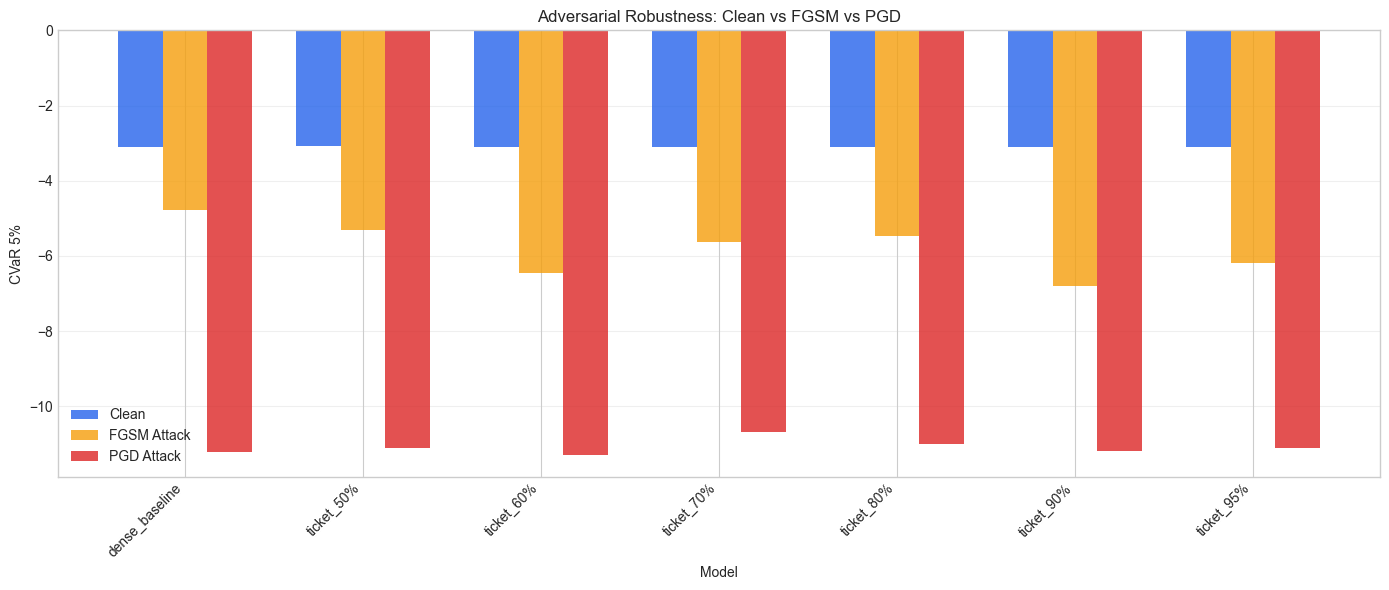

In [7]:
if len(results_attacks) > 0:
    model_names = list(results_attacks.keys())
    clean_cvars = [results_attacks[m]['clean']['cvar_05'] for m in model_names]
    fgsm_cvars = [results_attacks[m]['fgsm']['cvar_05'] for m in model_names]
    pgd_cvars = [results_attacks[m]['pgd']['cvar_05'] for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - width, clean_cvars, width, label='Clean', color='#2563eb', alpha=0.8)
    bars2 = ax.bar(x, fgsm_cvars, width, label='FGSM Attack', color='#f59e0b', alpha=0.8)
    bars3 = ax.bar(x + width, pgd_cvars, width, label='PGD Attack', color='#dc2626', alpha=0.8)
    
    ax.set_xlabel('Model')
    ax.set_ylabel('CVaR 5%')
    ax.set_title('Adversarial Robustness: Clean vs FGSM vs PGD')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../figures/robustness_comparison.pdf', dpi=300)
    plt.show()
else:
    print("No models to visualize")

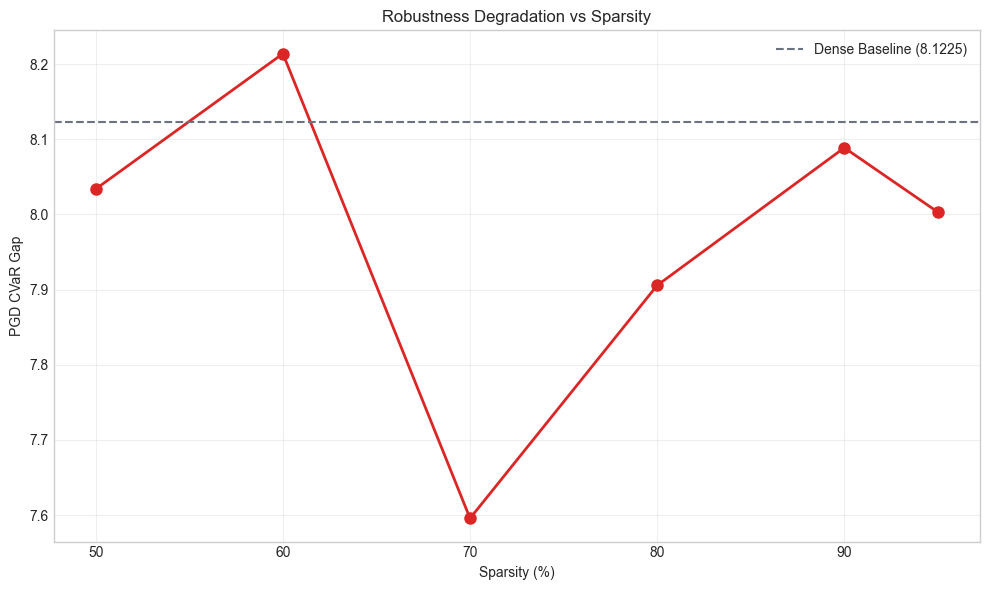

In [8]:
# Robustness gap vs sparsity
if len(results_attacks) > 1:
    # Extract sparsity levels from ticket names
    sparsities = []
    pgd_gaps = []
    
    for model_name, results in results_attacks.items():
        if 'ticket' in model_name:
            sparsity = int(model_name.split('_')[1].replace('%', ''))
            sparsities.append(sparsity)
            pgd_gaps.append(results['pgd_cvar_gap'])
    
    if sparsities:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(sparsities, pgd_gaps, 'o-', linewidth=2, markersize=8, color='#dc2626')
        
        # Add baseline gap if available
        if 'dense_baseline' in results_attacks:
            baseline_gap = results_attacks['dense_baseline']['pgd_cvar_gap']
            ax.axhline(baseline_gap, color='#6b7280', linestyle='--', 
                      label=f'Dense Baseline ({baseline_gap:.4f})')
        
        ax.set_xlabel('Sparsity (%)')
        ax.set_ylabel('PGD CVaR Gap')
        ax.set_title('Robustness Degradation vs Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../figures/robustness_vs_sparsity.pdf', dpi=300)
        plt.show()

### Summary

Key findings:
- Standard lottery tickets are vulnerable to adversarial attacks
- Robustness gap tends to increase with sparsity
- PGD attacks are more effective than FGSM
- This motivates the need for adversarial training of sparse networks